In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Choose Dataset

In [2]:
DATASET = 'mnist'
if DATASET     == 'mnist':
    epochs     = 500
    #lr         = 0.00004
    lr         = 0.05
    momentum   = 0.0    
    mean_imgs  = 0.1307
    std_imgs   = 0.3081
    imgs_shape = (1,28,28)

In [3]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
RES = os.path.join(ROOT,'results')

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm

from mnist_archs import LeNet
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [5]:
bs = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print(kwargs)

{'num_workers': 2, 'pin_memory': True}


In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(ROOT +  '/data/' + DATASET, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                                           
                   ])),
    batch_size=bs, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    
    datasets.MNIST(ROOT + '/data/' + DATASET, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                       
                   ])),
    batch_size=bs, shuffle=True, **kwargs)

In [7]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])


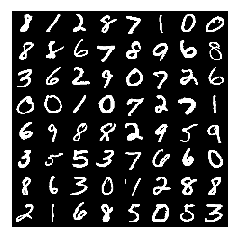

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

### Check labelling

Useful in case of random shuffling of labels

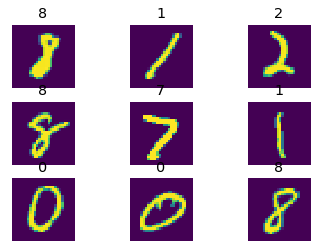

In [9]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i,0,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i].item())

# Initialize network, optimizer and loss

In [10]:
model = LeNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = F.nll_loss

In [11]:
print(model)
print( summary(model, imgs_shape) )

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]            5020
            Linear-3                   [-1, 50]           16050
            Linear-4                   [-1, 10]             510
Total params: tensor(21840)
Trainable params: tensor(21840)
Non-trainable params: tensor(0)
----------------------------------------------------------------
None


In [12]:
train_loss   = []
train_acc    = []
valid_loss   = []
valid_acc    = []

In [ ]:
F = []
for epoch in tqdm(range(epochs)):
    
    # init auxiliary grad and grad2
    auxgrad  = init_grad(model)
    auxgrad2 = init_grad(model)
    
        
    num_mb = 0
    for i, data in enumerate(train_loader, 0):
        
        num_mb += 1
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)  
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        # compute the grad
        loss.backward()
                
        # accumulate grad and grad2
        auxgrad  = acc_grad(auxgrad,model)
        auxgrad2 = acc_grad2(auxgrad2,model)
        
    
    # compute the snr 
    snr = compute_snr(auxgrad, auxgrad2, num_mb)
    
    # temper the grad with the information on grad2
    f = []
    with torch.no_grad():
        for param, s in zip(model.parameters(), snr): 
            
            #param.grad = torch.where(s > 1, param.grad, 
            #                          torch.zeros(param.grad.size()).to(device) )
            
            param.grad = torch.where(s > 1, param.grad, 
                                      s*param.grad)
            f.append(  ( s < 1).sum().item() / 
                     torch.prod(torch.tensor( s.size() ) ).item()  )       
    F.append(f)
    
    # this is now outside (modify learning rate accordingly ???)
    optimizer.step()
        
        
    # save model
    torch.save(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        
    # print statistics
    loss = 0.0
    total = 0    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            total += labels.size(0)
        l = loss/total
        valid_loss.append(l)
    
    loss = 0.0
    total = 0    
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            total += labels.size(0)
        l = loss/total
        train_loss.append(l)        
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct/total
        valid_acc.append(acc)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct/total
        train_acc.append(acc)
        
    # print statistics
    print('Test loss : %g --- Test acc : %g %%' % ( valid_loss[-1], valid_acc[-1] )) 
   

  0%|          | 1/500 [00:07<1:02:33,  7.52s/it]

Test loss : 0.0361782 --- Test acc : 8.92 %


  0%|          | 2/500 [00:14<1:01:35,  7.42s/it]

Test loss : 0.0361018 --- Test acc : 8.92 %


  1%|          | 3/500 [00:22<1:01:24,  7.41s/it]

Test loss : 0.0360779 --- Test acc : 9.1 %


  1%|          | 4/500 [00:29<1:01:44,  7.47s/it]

Test loss : 0.0359852 --- Test acc : 8.95 %


  1%|          | 5/500 [00:37<1:01:44,  7.48s/it]

Test loss : 0.0359087 --- Test acc : 9.8 %


  1%|          | 6/500 [00:44<1:01:37,  7.49s/it]

Test loss : 0.0358761 --- Test acc : 14.05 %


  1%|▏         | 7/500 [00:52<1:01:33,  7.49s/it]

Test loss : 0.035802 --- Test acc : 12.52 %


In [ ]:
# save loss and accuracies in a dictionary
tags = ['train_loss','valid_loss', 'train_acc', 'valid_acc' ]
vals = [train_loss, valid_loss, train_acc, valid_acc]
training_data = dict(zip(tags, vals))
file = open( os.path.join( RES, "training_data" ) , 'wb' ) 
pickle.dump(training_data,file)
print('Finished training.')

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,'-o',label='training loss')
plt.plot(valid_loss,'-o',label='test loss')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(train_acc,'-o',label='training accuracy')
plt.plot(valid_acc,'-o',label='test accuracy')
plt.xlabel('epoch')
plt.savefig(os.path.join(ROOT,'figures', 'mnist_first_try.png'))
plt.show()